In [1]:
import os
import random
import time

import numpy as np
import pandas as pd
import scipy as sc
from scipy.io import wavfile, loadmat
from scipy import signal
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.transforms import Compose

from sklearn.metrics import roc_curve, roc_auc_score

import tensorboardX
from tqdm import tqdm

import matplotlib.pyplot as plt

## Top-1 and Top-5 accuracy

In [ ]:
C = 7 # 1251 class num
SIZE = (1, C)
probs = torch.rand(SIZE) # net(spec)
label = torch.randint(C, size=(1,)).type(torch.LongTensor)
pred_top5 = probs.topk(5)[1]
pred_top1 = probs.topk(1)[1]
print(probs)
print(label)
print(pred_top5)
print(label in pred_top5.view(5))
print(label in pred_top1.view(1))
print(label == pred_top5.view(5)[0])
if label == pred_top5.view(5)[0]:
    print('it works')

## Overfitting model on a small dataset

In [ ]:
## Input (B, 1, 512, 298)
class VoiceNet(nn.Module):

    def __init__(self, num_classes=2):
        super(VoiceNet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=96, kernel_size=7, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        
        self.bn1 = nn.BatchNorm2d(num_features=96)
        self.bn2 = nn.BatchNorm2d(num_features=256)
        self.bn3 = nn.BatchNorm2d(num_features=256)
        self.bn4 = nn.BatchNorm2d(num_features=256)
        self.bn5 = nn.BatchNorm2d(num_features=256)
        self.bn6 = nn.BatchNorm2d(num_features=4096)
        self.bn7 = nn.BatchNorm1d(num_features=1024)
        
        self.relu = nn.ReLU()
        
        self.mpool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.mpool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.mpool5 = nn.MaxPool2d(kernel_size=(5, 3), stride=(3, 2))
        
        # Conv2d with weights of size (H, 1) is identical to FC with H weights
        self.fc6 = nn.Conv2d(in_channels=256, out_channels=4096, kernel_size=(9, 1))
        self.fc7 = nn.Linear(in_features=4096, out_features=1024)
        self.fc8 = nn.Linear(in_features=1024, out_features=num_classes)
        
    def forward(self, x):
        B, C, H, W = x.size()
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.mpool1(x)
        x = self.relu(self.bn2(self.conv2(x)))       
        x = self.mpool2(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.relu(self.bn4(self.conv4(x)))
        x = self.relu(self.bn5(self.conv5(x)))
        x = self.mpool5(x)
        x = self.relu(self.bn6(self.fc6(x)))
        
        _, _, _, W = x.size()
        self.apool6 = nn.AvgPool2d(kernel_size=(1, W))
        x = self.apool6(x)
        
        x = x.view(x.size(0), -1)
        x = self.relu(self.bn7(self.fc7(x)))
        x = self.fc8(x)
        
        # no need for SoftMax because CrossEntropyLoss calculates it
        if self.train:
            return x
        
        else:
            assert True == False, 'Decide what to do with SM on inference'
    
B = 3
SIZE0 = (100, 1, 512, 298)
SIZE1 = (100, 1, 512, 298)
SIZE2 = (100, 1, 512, 298)
model_input_size = (B, 1, 512, 298)

In [ ]:
## Input (B, 3, 32, 32)
class VoiceNet(nn.Module):
    "Implementation Ref: https://github.com/kuangliu/pytorch-cifar"
    def __init__(self, num_classes=None):
        super(VoiceNet, self).__init__()
        VGG16 = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 
                 512, 512, 512, 'M', 512, 512, 512, 'M']
        self.features = self._make_layers(VGG16)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)
    

SIZE0 = (100, 3, 32, 32)
SIZE1 = (100, 3, 32, 32)
SIZE2 = (100, 3, 32, 32)
model_input_size = (B, 3, 32, 32)

In [ ]:
DATASET_PATH = '/home/nvme/data/vc1/'
LOG_PATH = '/home/nvme/logs/VoxCeleb/_model_overfit_test'
EPOCH_NUM = 30
B = 96
WEIGHT_DECAY = 5e-4
LR_INIT = 1e-2
LR_LAST = 1e-4
# lr scheduler parameter
gamma = 10 ** (np.log10(LR_LAST / LR_INIT) / (EPOCH_NUM - 1))
MOMENTUM = 0.9
DEVICE = 'cuda:1'
NUM_WORKERS = 4
EVAL_THRESHOLD = 0.5
TBoard = tensorboardX.SummaryWriter(log_dir=LOG_PATH)

In [ ]:
net = VoiceNet(num_classes=3)
net.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), 1e-7, MOMENTUM, weight_decay=WEIGHT_DECAY)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=gamma)

B = 3

class0_data = torch.rand(SIZE0) - 20
class1_data = torch.rand(SIZE1) + 20
class2_data = torch.rand(SIZE2)

labels0 = torch.zeros(100).type(torch.LongTensor)
labels1 = torch.ones(100).type(torch.LongTensor)
labels2 = torch.ones(100).type(torch.LongTensor) * 2

dataset = torch.cat([class0_data, class1_data, class2_data])
datalabels = torch.cat([labels0, labels1, labels2])

shuffling_idxs = torch.randperm(len(dataset))
dataset = dataset[shuffling_idxs]
datalabels = datalabels[shuffling_idxs]

for epoch_num in range(EPOCH_NUM):
#     lr_scheduler.step()
    
    # train
    net.train()
    
#     for iter_num, specs in tqdm(enumerate(dataset)):
    for i in tqdm(range(len(dataset) // B)):
        labels, specs = datalabels[i*B:i*B+B].view(B), dataset[i*B:i*B+B].view(model_input_size)
        optimizer.zero_grad()
        labels, specs = labels.to(DEVICE), specs.to(DEVICE)
        probs = net(specs)
        loss = criterion(probs, labels)
        loss.backward()
        optimizer.step()

        # TBoard
        step_num = epoch_num * (len(dataset)//3) + i
        TBoard.add_scalar('TrainLoss', loss.item(), step_num)

## Datasets debug

In [ ]:
transforms = Compose([
    Normalize(),
    ToTensor()
])

trainset = IdentificationDataset(DATASET_PATH, train=True, transform=transforms)
trainsetloader = torch.utils.data.DataLoader(trainset, batch_size=3)

testset = IdentificationDataset(DATASET_PATH, train=False, transform=transforms)
testsetloader = torch.utils.data.DataLoader(testset, batch_size=1)

for i, a in enumerate(trainsetloader, 0):
    labels, specs = a
    print(labels, specs)
    if i > 2:
        break

for i, a in enumerate(testsetloader, 0):
    labels, specs = a
    print(labels, specs)
    if i > 10:
        break

## Spectrogram comparison

In [38]:
audio_path = 'Y8hIVOBuels_0000002.wav'
# read
rate, samples = wavfile.read(audio_path)

## parameters
window = 'hamming'
# window width and step size
Tw = 25
Ts = 10
# frame duration (samples)
Nw = int(rate * Tw * 1e-3)
# overlapped duration (samples)
# 2 ** to the next pow of 2
Ns = int(rate * (Tw - Ts) * 1e-3)
nfft = 2 ** (Nw - 1).bit_length()
pre_emphasis = 0.97

# preemphasis filtering
samples = np.append(samples[0], samples[1:] - pre_emphasis * samples[:-1])

# removes DC component of the signal and add a small dither
samples = signal.lfilter([1, -1], [1, -0.99], samples)
dither = np.random.uniform(-1, 1, samples.shape)
spow = np.std(samples)
samples = samples + 1e-6 * spow * dither

# spectogram
frequencies, times, spectrogram = signal.spectrogram(samples, rate, window, Nw, Ns, nfft, 
                                mode='magnitude', return_onesided=False)

spectrogram *= 1600

print(spectrogram.shape)

(512, 1110)


/home/vladimir/venv/lib/python3.5/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


In [39]:
np.random.uniform(-1, 1, samples.shape)

array([ 0.25429718, -0.28907366,  0.97382544, ..., -0.93428938,
        0.52150083,  0.7243767 ])

(512, 1110)


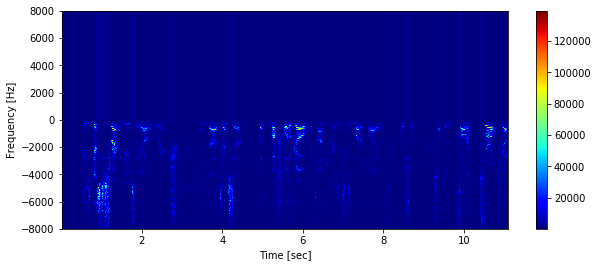

In [40]:
plt.figure(figsize=(10, 4))
plt.pcolormesh(times, frequencies, spectrogram, cmap=plt.cm.jet)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
print(spectrogram.shape)
plt.show()

In [41]:
mat = loadmat('SPEC.mat')

(512, 1110)


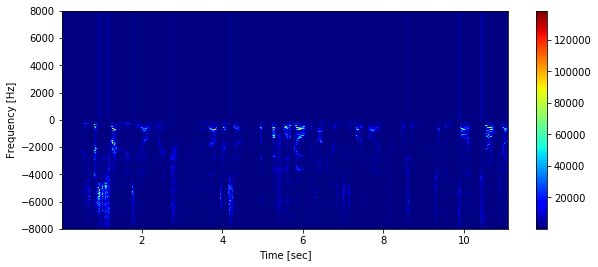

In [42]:
plt.figure(figsize=(10, 4))
plt.pcolormesh(times, frequencies, mat['SPEC'], cmap=plt.cm.jet)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar()
print(spectrogram.shape)
plt.show()

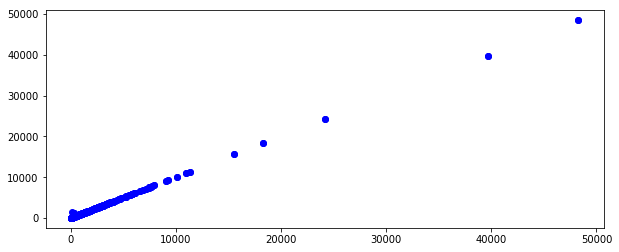

In [43]:
plt.figure(figsize=(10, 4))
plt.plot(mat['SPEC'][:, 200], spectrogram[:, 200], 'bo')

In [44]:
spectrogram[:, 123] / mat['SPEC'][:, 123]

array([9.5187637 , 4.17476761, 0.99095032, 0.99786696, 1.00403948,
       1.00662284, 1.0030418 , 1.00347249, 0.9964764 , 1.00673047,
       1.00690571, 1.00453671, 1.00950429, 1.03253427, 1.01057446,
       1.00939049, 1.00858435, 1.00454545, 1.01018849, 1.00793012,
       1.0072226 , 1.00613768, 1.00116373, 1.00895517, 1.01148531,
       1.00904596, 1.00506124, 0.99581272, 0.99915066, 1.00423514,
       1.00916641, 1.00608972, 1.00302189, 1.00573574, 1.00872079,
       1.00687059, 1.00214948, 1.0055229 , 1.01460549, 1.01530107,
       1.01020017, 1.00520896, 1.01028806, 1.01698892, 1.01087753,
       1.01006837, 1.0017881 , 1.00949995, 1.0797883 , 1.00822215,
       1.00863577, 1.0086825 , 1.00582039, 1.03082647, 1.00994978,
       1.01218024, 1.00689661, 1.00331363, 1.00611858, 1.00903595,
       1.0111783 , 1.00940725, 1.00905394, 1.01267233, 1.01341568,
       1.01168034, 1.00591883, 1.00068851, 1.00269088, 0.99850891,
       1.00566553, 0.99730865, 1.0014962 , 0.99821137, 1.00846

In [ ]:
plt.matshow(spectrogram);

In [ ]:
plt.matshow(mat['SPEC']);

## Thought the model also uses frames

In [ ]:
class IdentificationDataset(Dataset):
    
    def __init__(self, path, train):
        iden_split_path = os.path.join(path, 'iden_split.txt')
        split = pd.read_table(iden_split_path, sep=' ', header=None, names=['phase', 'path'])
        
        if train:
            phases = [1, 2]
        
        else:
            phases = [3]
            
        mask = split['phase'].isin(phases)
        self.dataset = split['path'][mask].reset_index(drop=True)
        self.path = path
        self.train = train
        print(self.dataset.head(10))
    
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        track_path = self.dataset[idx]
        print(track_path)
        
        ## FACE
        frames_path = os.path.join(self.path, 'video', track_path.replace('.wav', '.txt'))
        frames_table = pd.read_table(frames_path, skiprows=6, usecols=['FRAME '])
        mask = np.where(frames_table.values % 25 == 0)
        # Note: only 20 per each face-track (see the asterics on the project page)
        # frames_1fps = frames_table[mask]
        frames_1fps = frames_table.values[mask][:20]
        print(frames_1fps)
        selected_frame = np.random.choice(frames_1fps)
        print(selected_frame)
        selected_frame_filename = '{0:07d}.jpg'.format(selected_frame)
        # cut off filename and extention. Add selected filename
        selected_frame_path = os.path.join(self.path, 'video', track_path[:-10], selected_frame_filename)
        print(selected_frame_path)
        
        
        # load this frame
        
        ## AUDIO
        audio_path = os.path.join(self.path, 'audio', track_path)
        
        return 1